## Laboratoire 2

In [10]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import math
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from deeplib.visualization import make_vizualization_autograd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Graphe computationnel et backprop
Cette section a pour but de vous familiariser avec les notions de graphe computationnel et de backpropagation, plus particulièrement leur implémentation PyTorch. Dans le dernier laboratoire, vous avez vu une version haut-niveau de l'entraînement de réseaux de neurones. À l'inverse, ce laboratoire a pour but de vous donner une intuition du fonctionnement interne de PyTorch. Qui sait? Peut-être voudrai vous un jour implémenter vous même votre librairie de graphe de calcul.

#### Tenseurs et Variables
La structure de données de base dans PyTorch est le `Tensor`. Cette structure de données est comparable au `ndarray` numpy. Le package `torch.Tensor` défini des matrices multidimensionnelles et les opérations sur celles-ci. Voici quelques exemples: 

In [11]:
# Création et initialisation à une normale centrée à 0 et de variance 1.
a = torch.Tensor(10,10)
print(a) # Initialement, le tenseur contient du 'garbage'. Il peut même contenir des NaN
a.normal_()
print(a)
print(torch.mean(a))

tensor([[-4.1477e-04,  3.0859e-41,  9.3887e-44,  1.5975e-43,  3.2650e-43,
          1.3593e-43,  1.6255e-43,  1.4714e-43,  1.5554e-43,  1.5414e-43],
        [ 4.4842e-44,  1.4153e-43,  1.6255e-43,  4.4842e-44,  1.4714e-43,
          1.5414e-43,  1.4714e-43,  1.6255e-43,  1.4714e-43,  1.3593e-43],
        [ 1.5134e-43,  1.4714e-43,  1.6115e-43,  1.3593e-43,  1.6255e-43,
          1.4714e-43,  1.5554e-43,  1.5414e-43,  4.4842e-44,  3.1389e-43],
        [ 4.4842e-44,  1.6395e-43,  1.5414e-43,  1.4153e-43,  4.4842e-44,
          1.5414e-43,  1.5554e-43,  1.5975e-43,  1.5274e-43,  1.3593e-43],
        [ 1.5134e-43,  1.4153e-43,  4.4842e-44,  1.3873e-43,  1.4153e-43,
          1.5414e-43,  1.6255e-43,  1.5975e-43,  3.2650e-43,  1.4153e-43],
        [ 4.4842e-44,  3.1389e-43,  4.4842e-44,  6.7262e-44,  4.4842e-44,
          1.4153e-43,  1.6255e-43,  4.4842e-44,  1.4013e-43,  1.4153e-43],
        [ 4.4842e-44,  1.6535e-43,  1.3593e-43,  1.5975e-43,  1.4714e-43,
          1.3593e-43,  1.5414e-4

> **REMARQUE** Dans l'exemple précédent, la méthode `normal_()` se termine par un underscore. Cela signifie que cette méthode fait une mutation du `Tensor`.

In [14]:
b = torch.Tensor(10,1).fill_(1)
print(b)
print(a.matmul(b))
print(torch.matmul(a,b))

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]])
tensor([[ 1.3746],
        [ 0.6996],
        [-4.8276],
        [ 2.0546],
        [ 2.4959],
        [ 1.1584],
        [-1.4900],
        [-0.5789],
        [-0.2253],
        [-1.3909]])
tensor([[ 1.3746],
        [ 0.6996],
        [-4.8276],
        [ 2.0546],
        [ 2.4959],
        [ 1.1584],
        [-1.4900],
        [-0.5789],
        [-0.2253],
        [-1.3909]])


On peut facilement transférer un `Tensor` sur GPU. Les opérations sur ces `Tensor` seront exécutées sur GPU.

In [4]:
a_gpu = a.cuda()
b_gpu = b.cuda()
print(a_gpu.matmul(b_gpu))
print(a_gpu.matmul(b_gpu).cpu())

tensor([[-3.4672],
        [-2.6829],
        [ 2.5347],
        [ 0.1980],
        [ 1.4281],
        [ 0.5420],
        [-5.5045],
        [-0.4362],
        [ 2.8634],
        [-6.1170]], device='cuda:0')
tensor([[-3.4672],
        [-2.6829],
        [ 2.5347],
        [ 0.1980],
        [ 1.4281],
        [ 0.5420],
        [-5.5045],
        [-0.4362],
        [ 2.8634],
        [-6.1170]])


In [5]:
#TODO corrigez cette opération pour multiplier `a` avec `c_gpu` sur cpu
c_gpu = a_gpu.matmul(b_gpu)
print(a.matmul(c_gpu))

RuntimeError: Expected object of type torch.FloatTensor but found type torch.cuda.FloatTensor for argument #2 'mat2'

Depuis PyTorch 1.0, l'API Variable est discontinué. Nous pouvons simplement spécifier ```requires_grad=True``` au Tensor en question pour activer le calcul des gradients.

In [15]:
a.requires_grad = True
b.requires_grad = True
a, b

(tensor([[-0.7960,  0.3774, -0.8984,  0.1929,  0.8083,  2.0825, -0.1646, -1.2096,
           1.3248, -0.3426],
         [ 0.2241,  3.2622, -0.1419, -1.1070,  0.7393, -0.3129, -0.4866, -0.5345,
          -1.0182,  0.0750],
         [-1.3754, -0.6875, -0.5257, -0.5118, -0.9184,  0.6913, -0.1297, -1.2284,
          -1.6490,  1.5070],
         [-1.3692,  0.3762,  0.6209,  0.0948,  0.6489,  0.3025,  0.1357,  0.4057,
           0.2284,  0.6108],
         [-0.4635, -1.0200,  0.3228,  0.0493, -2.0384,  0.8075,  0.8384,  0.8824,
           0.6155,  2.5019],
         [-0.5670, -0.1424,  0.1656, -0.0255, -1.3152,  0.9193, -0.8610, -0.1010,
           1.8340,  1.2516],
         [ 1.2076, -0.9696, -0.3323,  1.8658,  0.3970, -0.6181, -0.5463, -0.5000,
          -1.1416, -0.8526],
         [ 0.2876,  0.7499, -1.0379, -1.2912, -0.5997, -0.8787,  0.8241,  0.6530,
          -0.0515,  0.7656],
         [-0.0361,  0.8185, -0.0979,  0.9052,  0.6045, -2.0238, -0.1961, -0.3980,
           0.7610, -0.5626],
 

En règle générale, les opérations in-place, c'est-à-dire les opérations qui font une mutation directe d'un ```Tensor``` (et qui se terminent par un underscore), ne sont pas disponibles lorsque ```requires_grad``` est égale à ```True```.

In [16]:
a.uniform_()

RuntimeError: a leaf Variable that requires grad has been used in an in-place operation.

```Tensor``` contient quelques attributs intéressant comme les données et le gradient.

In [17]:
print(type(a))
print(type(a.data))
print(a.grad)

<class 'torch.Tensor'>
<class 'torch.Tensor'>
None


Nous allons voir dans la prochaine section comment faire la backpropagation du gradient.

#### Gradient et Backpropagation

Variable provient du package `torch.autograd`. Comme le nom du package l'indique, il est possible d'automatiquement calculer la dérivée de fonctions calculées à partir d'opérations sur les variables. On indique les Variables qu'on veut dériver avec `requires_grad=True` (par défaut à False). Dans l'exemple suivant, lors du calcul de `w` (propagation avant), PyTorch construit dynamiquement un graphe de calcul indiquant les liens de dépendance entre les variables et les opérations, ce qui permet la backpropagation.

> **NOTE** Contrairement à des librairies comme Tensorflow où le graphe de calcul est statique, PyTorch recrée dynamique le graphe de calcul à chaque itération. Cela permet de modifier la structure du graphe dynamiquement avec du code Python. Par contre, cela rend la visualisation du graphe plus difficile. 


In [18]:
x = torch.Tensor(3, 3).uniform_(-1, 1)

y = torch.Tensor(3, 3).uniform_(-1, 1)
y.requires_grad = True

z = torch.Tensor(3, 3).uniform_(-1, 1)
z.requires_grad = True

f = torch.matmul(x, y) + x + y + z

print(x, y, z, f)

tensor([[ 0.5859, -0.0982,  0.0089],
        [-0.0021, -0.2330,  0.1494],
        [ 0.4645, -0.0151, -0.3053]]) tensor([[-0.6605, -0.4884, -0.2380],
        [ 0.7619, -0.5407,  0.1615],
        [ 0.2172,  0.0072,  0.1218]], requires_grad=True) tensor([[ 0.9510, -0.2446, -0.1744],
        [ 0.5467, -0.3480, -0.5049],
        [ 0.7979, -0.0692, -0.1334]], requires_grad=True) tensor([[ 0.4166, -1.0643, -0.5577],
        [ 1.1628, -0.9936, -0.2129],
        [ 1.0949, -0.2980, -0.4671]], grad_fn=<ThAddBackward>)


None
None
None
None


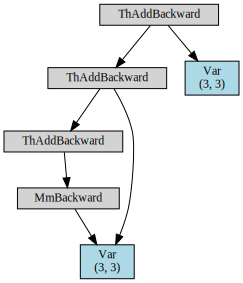

In [19]:
print(f.grad_fn)

print(x.grad)
print(y.grad)
print(z.grad)
print(f.grad)

make_vizualization_autograd(f)

In [20]:
f_grad = torch.ones(f.size())
f.backward(f_grad)

In [21]:
print(x.grad)
print(y.grad)
print(z.grad)
print(f.grad)

None
tensor([[2.0483, 2.0483, 2.0483],
        [0.6537, 0.6537, 0.6537],
        [0.8531, 0.8531, 0.8531]])
tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]])
None


##### Questions
- Exécutez deux fois la cellule qui appelle la fonction .backward(). Qu'arrive-t-il? Pourquoi?
- Quelles tensors auraient requires_grad=False dans le contexte d'entraînement de réseaux de neurones?
- Dans l'exemple précédent, pourquoi `f` n'a-t-il pas de gradient?

##### TODO exercice
Faites la mise-à-jour des valeurs de y et z et soustrayant $1 \times 10^{-3}$ fois leur gradient

In [ ]:
# TODO

#### Prévenir le calcul de gradient

Pour éviter de caluler les gradients pour certains tensor, nous utiliserons la méthode `torch.no_grad()`.

In [25]:
x = torch.Tensor(3, 3).uniform_(-1, 1)

y = torch.Tensor(3, 3).uniform_(-1, 1)
y.requires_grad = True

z = torch.Tensor(3, 3).uniform_(-1, 1)
z.requires_grad = True

f = torch.matmul(x, y) + x + y + z

print(f.requires_grad)

True


In [26]:
with torch.no_grad():
    f = torch.matmul(x, y) + x + y + z

print(f.requires_grad)

False


##### Question
- Dans quel contexte voudrait-on ne calculer aucun gradient d'un graphe de calcul?

### Fonction d'activation

La section suivante a pour but d'explorer les différences entre les fonctions d'activation ReLU et Tanh.

#### Question préalable
- À quoi sert la fonction d'activation? Sans elle, que devient un réseau multi-couches?

#### Visualisation du dataset
Pour cette partie, nous utiliserons le dataset des spirales. Vous pouvez voir le code qui a servi à générer le dataset dans la librairie https://github.com/ulaval-damas/glo4030-labs/blob/master/deeplib/datasets.py

(1000, 7) (1000,)


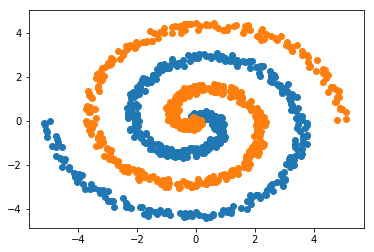

In [27]:
from deeplib.datasets import SpiralDataset, train_valid_loaders

dataset = SpiralDataset()
points, labels = dataset.to_numpy()
print(points.shape, labels.shape)
plt.scatter(points[labels==1,0], points[labels==1,1])
plt.scatter(points[labels==0,0], points[labels==0,1])

Dans la cellule suivante,  `train_valid_loaders()` retourne des [DataLoader](http://pytorch.org/docs/0.3.0/data.html#torch.utils.data.DataLoader) pytorch. Il est possible d'itérer sur les données d'un `DataLoader` comme on le ferait sur un liste python.

> **PYTHON DEEP DIVE** Pourquoi peut-on itérer facilement sur le `DataLoader`? Parce que la classe implémente la méthode `__iter__`. Ainsi, quand on fait
```
for x in data_loader:
```
la fonction `__iter__` est appelée, ce qui crée un itérateur sur le `DataLoader`. Cet itérateur peut charger les données sur demande puis que la méthode `__next__` est appelée à chaque itération. Il est possible de créer explicitement cet itérateur en appelant la fonction built-in `iter()`.

In [28]:
train_loader, valid_loader = train_valid_loaders(dataset, 8)

for i, (data, label) in enumerate(train_loader):
    print(data, label)
    if i > 10:
        break

tensor([[-2.4970e-02, -3.6307e-01,  6.2350e-04,  1.3182e-01,  9.0659e-03,
         -2.4967e-02, -3.5515e-01],
        [ 8.7564e-01, -4.6407e-01,  7.6674e-01,  2.1537e-01, -4.0636e-01,
          7.6795e-01, -4.4760e-01],
        [ 3.5959e+00, -1.2986e+00,  1.2930e+01,  1.6862e+00, -4.6694e+00,
         -4.3880e-01, -9.6317e-01],
        [ 1.5383e+00,  1.1558e+00,  2.3662e+00,  1.3358e+00,  1.7779e+00,
          9.9947e-01,  9.1510e-01],
        [ 2.1712e+00,  2.0282e+00,  4.7139e+00,  4.1134e+00,  4.4035e+00,
          8.2513e-01,  8.9722e-01],
        [-1.4557e+00,  2.0862e+00,  2.1191e+00,  4.3524e+00, -3.0370e+00,
         -9.9339e-01,  8.7008e-01],
        [-1.7634e+00, -4.2397e+00,  3.1097e+00,  1.7975e+01,  7.4764e+00,
         -9.8150e-01,  8.9035e-01],
        [ 3.1803e+00,  3.3673e+00,  1.0115e+01,  1.1339e+01,  1.0709e+01,
         -3.8738e-02, -2.2378e-01]]) tensor([0, 1, 1, 0, 1, 1, 1, 0])
tensor([[ 6.8420e-01,  1.2923e+00,  4.6813e-01,  1.6699e+00,  8.8417e-01,
          6.

Comme pour tout itérateur python, on peut utiliser `itertools`. Par exemple, ici, on boucle sur les 10 premiers éléments de l'itérateur:

In [29]:
import itertools
for data in itertools.islice(iter(train_loader), 10):
    print(data)

[tensor([[-0.6936,  1.1147,  0.4810,  1.2426, -0.7731, -0.6393,  0.8978],
        [-0.6085,  1.0670,  0.3703,  1.1384, -0.6493, -0.5717,  0.8757],
        [ 0.9441, -0.1497,  0.8914,  0.0224, -0.1414,  0.8100, -0.1492],
        [-0.3746,  1.3828,  0.1404,  1.9121, -0.5180, -0.3659,  0.9824],
        [-0.4969, -0.0643,  0.2469,  0.0041,  0.0320, -0.4767, -0.0643],
        [-1.4027, -4.1621,  1.9676, 17.3228,  5.8381, -0.9859,  0.8524],
        [ 0.7419,  1.6055,  0.5504,  2.5776,  1.1911,  0.6757,  0.9994],
        [-4.8770, -1.1485, 23.7848,  1.3190,  5.6012,  0.9865, -0.9121]]), tensor([0, 0, 1, 0, 0, 1, 0, 1])]
[tensor([[ 0.9331,  1.4606,  0.8707,  2.1332,  1.3629,  0.8035,  0.9939],
        [ 2.9050,  3.8275,  8.4387, 14.6498, 11.1187,  0.2344, -0.6334],
        [-3.6120, -3.0842, 13.0464,  9.5125, 11.1402,  0.4532, -0.0573],
        [ 0.8852, -0.1474,  0.7836,  0.0217, -0.1305,  0.7741, -0.1469],
        [ 0.5414, -1.1150,  0.2931,  1.2432, -0.6036,  0.5153, -0.8979],
        [-0.1

In [30]:
print(next(iter(train_loader)))

[tensor([[ 3.5426, -0.4617, 12.5497,  0.2132, -1.6356, -0.3903, -0.4455],
        [ 2.0263,  0.1703,  4.1058,  0.0290,  0.3452,  0.8980,  0.1695],
        [ 1.4401, -2.1702,  2.0739,  4.7096, -3.1253,  0.9915, -0.8257],
        [-0.7450,  0.0400,  0.5551,  0.0016, -0.0298, -0.6780,  0.0400],
        [ 0.4615, -0.8320,  0.2129,  0.6923, -0.3839,  0.4452, -0.7393],
        [-1.9112, -0.5602,  3.6527,  0.3138,  1.0707, -0.9426, -0.5314],
        [ 1.5182,  1.0723,  2.3049,  1.1498,  1.6279,  0.9986,  0.8783],
        [-3.7136,  0.6644, 13.7907,  0.4415, -2.4674,  0.5413,  0.6166]]), tensor([1, 0, 0, 0, 1, 1, 0, 0])]


#### Création de modèles

Ici, on crée des classes qui héritent de `torch.nn.Module`. C'est la classe de base de tout réseau dans pytorch. `Module` comporte par exemple la méthode `named_parameters()` qui permet d'obtenir toutes les variables entraînables du `Module` ainsi que leur nom. Voici un lien vers la documentation complète:
http://pytorch.org/docs/0.3.0/nn.html#torch.nn.Module.

##### Exercice
Écrivez la fonction forward de TanhModel et ReluModel

In [31]:
class RandomModel(torch.nn.Module):
    
    def __init__(self, n_layers):
        super().__init__()
        torch.manual_seed(12345) # Both Tanh model and ReLU model will have the same random weights
        
        self.layers = []
        for i in range(n_layers):
            layer = nn.Linear(7,7)
            layer.weight.data.normal_(0.0, math.sqrt(2 / 7))
            layer.bias.data.fill_(0)
            self.layers.append(layer)
            self.add_module('layer-%d' % i, layer)
        self.output_layer = nn.Linear(7,2)

        self.nonzero_grad_stats = None
        
    
    def forward(self):
        raise NotImplementedError('Defined in children classes')
       
    
    def _forward_output_layer(self, x):
        out = self.output_layer.forward(x)
        out = F.log_softmax(out, dim=0)
        return out
        
    
    def print_weights_grads(self):
        self.nonzero_grad_stats = []
        for i, layer in enumerate(self.layers):
            print("-----\nLayer %d" % i)
            print("Weight:\n%sWeight gradient:\n%s\n" % (str(layer.weight.data), 
                                                         str(layer.weight.grad)))
            if layer.weight.grad is not None:
                nonzero_grad_indices = torch.nonzero(layer.weight.grad.data)
                nonzero_grad = [layer.weight.grad.data[i,j] for (i,j) in nonzero_grad_indices]
                nonzero_grad_mean = np.mean(np.abs(nonzero_grad))
                self.nonzero_grad_stats.append((len(nonzero_grad), nonzero_grad_mean))
                print("Number of nonzero gradient: %f" % len(nonzero_grad))
                print("Nonzero grad mean: %f" % nonzero_grad_mean)
        

        
class RandomReluModel(RandomModel):
    
    def __init__(self, n_layers):
        super().__init__(n_layers)
        
    
    def forward(self, x):
        pass
        
        
        
class RandomTanhModel(RandomModel):
    
    def __init__(self, n_layers):
        super().__init__(n_layers)
        
    
    def forward(self, x):
        pass


In [32]:
relu_model = RandomReluModel(10)
tanh_model = RandomTanhModel(10)
relu_model.print_weights_grads()
tanh_model.print_weights_grads()

-----
Layer 0
Weight:
tensor([[-0.3526, -0.7481, -0.3664, -0.0214,  0.8256,  0.6263, -0.2033],
        [ 0.9266,  0.4668,  0.5364,  0.8169,  0.2559, -0.7068, -0.1350],
        [-1.1160, -0.3064, -0.7955,  0.2473,  0.4237,  1.0606, -0.2491],
        [ 1.0780, -0.5208,  0.2758,  0.0120, -0.6570,  0.1587,  0.9044],
        [ 0.1614,  0.0300, -0.2369,  0.3602, -0.1150,  0.2094, -0.5939],
        [ 0.2099,  0.0067, -0.1007,  0.0333, -0.0764, -0.0471, -0.1293],
        [-0.4333,  0.5793,  0.1326,  0.7287,  0.5808, -0.0513,  0.4890]])Weight gradient:
None

-----
Layer 1
Weight:
tensor([[ 0.0242,  0.1164,  0.4192, -0.9414,  0.9430,  0.1859,  0.3455],
        [ 0.3670,  0.8510,  0.2315, -0.3758,  0.1511,  0.8824,  0.2419],
        [ 0.1758,  0.0703, -0.6284, -0.5292, -0.9301, -1.1800,  0.2042],
        [ 1.1206, -0.1256, -0.2281,  0.1875,  0.4249,  0.1399, -0.0889],
        [ 1.0258,  0.5543,  0.4392, -0.1527, -0.7752, -0.2811, -0.1861],
        [-0.1664, -0.2569, -0.3510, -0.9809,  0.5899,  0.

In [33]:
data_in, data_out = next(iter(train_loader))
relu_output = relu_model.forward(Variable(data_in))
tanh_output = tanh_model.forward(Variable(data_in))
print(data_in)
print("ReLU model ouput:\n", relu_output)
print("tanh model ouput:\n", tanh_output)

tensor([[-2.3972, -2.1135,  5.7464,  4.4670,  5.0665, -0.6776, -0.8563],
        [-0.1815, -0.2374,  0.0330,  0.0564,  0.0431, -0.1805, -0.2352],
        [-0.6487, -1.5973,  0.4207,  2.5513,  1.0361, -0.6041, -0.9996],
        [-1.9112, -0.5602,  3.6527,  0.3138,  1.0707, -0.9426, -0.5314],
        [ 0.8331, -0.7917,  0.6940,  0.6268, -0.6596,  0.7400, -0.7115],
        [ 2.5585,  1.9516,  6.5460,  3.8087,  4.9931,  0.5506,  0.9284],
        [-1.8898, -0.6932,  3.5713,  0.4806,  1.3100, -0.9496, -0.6390],
        [-2.2680, -3.9058,  5.1436, 15.2554,  8.8582, -0.7667,  0.6920]])
ReLU model ouput:
 None
tanh model ouput:
 None


#### TODO Exercice
Vérifiez que le réseau retourne bel et bien des probabilités. Identifiez la ligne de code qui transforme des nombres arbitraires en probabilité. Indice: il y a une erreur volontaire dans le code que vous devez corriger.

#### Analyse du modèle

In [ ]:
loss = torch.nn.NLLLoss()
relu_loss = loss(relu_output, Variable(data_out))
tanh_loss = loss(tanh_output, Variable(data_out))
print(relu_loss, tanh_loss)

In [ ]:
relu_loss.backward()
tanh_loss.backward()
relu_model.print_weights_grads()
tanh_model.print_weights_grads()

Le graphique suivant représente la quantité de poids qui ont un gradient nul lors de la backprop en fonction du numéro de la couche. 

In [ ]:
plt.plot(np.arange(len(relu_model.nonzero_grad_stats)), [x[0] for x in relu_model.nonzero_grad_stats], label='ReLU')
plt.plot(np.arange(len(tanh_model.nonzero_grad_stats)), [x[0] for x in tanh_model.nonzero_grad_stats], label='Tanh')
plt.legend()

Le graphique suivant représente le gradient moyen (sans tenir compte des gradients nuls) en fonction du numéro de couche. La partie du bas est un zoom sur les premières couches.

In [ ]:
fig, axs = plt.subplots(2)
axs[0].plot(np.arange(len(relu_model.nonzero_grad_stats)), [x[1] / x[0] for x in relu_model.nonzero_grad_stats],label='ReLU')
axs[0].plot(np.arange(len(tanh_model.nonzero_grad_stats)), [x[1] / x[0] for x in tanh_model.nonzero_grad_stats],label='Tanh')
axs[0].legend()
axs[1].plot(np.arange(4), [x[1] / x[0] for x in relu_model.nonzero_grad_stats[:4]])
axs[1].plot(np.arange(4), [x[1] / x[0] for x in tanh_model.nonzero_grad_stats[:4]])
plt.show()

La cellule suivante compte le nombre de fois que chaque poids a un gradient non-nul en passant plusieurs points dans le réseaux et en incrémentant le compteur à chaque fois que cela arrive.

In [ ]:
layer_index = 1
heatmap = np.zeros((7,7))
n_batch = 0
for data in train_loader:
    n_batch += 1
    data_in = Variable(data[0])
    relu_model.forward(data_in)
    nonzero_grad_indices = torch.nonzero(relu_model.layers[layer_index].weight.grad.data)
    for (i, j) in nonzero_grad_indices:
        heatmap[i,j] += 1
print(n_batch)
print(heatmap)

#### Entraînement

In [ ]:
from torch.optim import SGD

n_epoch = 1000
relu_losses = []
tanh_losses = []
relu_optimizer = SGD(relu_model.parameters(), lr=0.001, momentum=0.9, nesterov=True)
tanh_optimizer = SGD(tanh_model.parameters(), lr=0.001, momentum=0.9, nesterov=True)

for epoch in range(n_epoch):
    if epoch % 100 == 0:
        print("================\nEpoch %d done." % epoch)
    relu_epoch_losses = []
    tanh_epoch_losses = []
    for data_in, data_out in map(lambda data: (Variable(data[0]), Variable(data[1])),
                                 train_loader):
        relu_optimizer.zero_grad()
        tanh_optimizer.zero_grad()
        
        relu_loss = loss(relu_model(data_in), data_out)
        tanh_loss = loss(tanh_model(data_in), data_out)
        relu_epoch_losses.append(float(relu_loss))
        tanh_epoch_losses.append(float(tanh_loss))
        
        relu_loss.backward()
        tanh_loss.backward()
        relu_optimizer.step()
        tanh_optimizer.step()
    relu_losses.append(np.mean(np.asarray(relu_epoch_losses)))
    tanh_losses.append(np.mean(np.asarray(tanh_epoch_losses)))

In [ ]:
plt.plot(np.arange(len(relu_losses)), np.asarray(relu_losses),label='ReLU')
plt.plot(np.arange(len(tanh_losses)), np.asarray(tanh_losses),label='Tanh')
plt.legend()

#### Questions
- Observez la distribution du gradient lors de la backprop. Quelles différences y a-t-il entre la backprop à travers ReLU et à travers tanh?
- Est-ce que, pour deux entrées différentes, les mêmes poids ont un gradient élevé?
- Changez le nombre de couches du réseau. Qu'observez-vous?
- Changez la moyenne de la gaussienne des poids lors de l'initilisation. Qu'observez-vous?
- Identifiez un problème avec la tanh. Identifiez un problème avec la ReLU.